# Climate and vegetation

- Variables are vegetation (`NDVI_mm`) and climate (`SWVL1_mm`, `STL1_mm`, `WB_mm`, `WD_mm`, `TP_mm`, `E_mm`, `RELHUM_mm`, `SSR_mm`, and `T2M_mm`).
- Principal Component Analysis for all South America grid points.
- K-Means for the first principal component.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob
import progressbar

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)
print(">>> Version of pandas:", pd.__version__)

>>> Version of xarray: 0.14.0
>>> Version of pandas: 0.25.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn
from cdlearn.auxiliary import dict_units, dict_titles_pt

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly observed data

In [6]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_mm", 
    "SWVL1_mm", 
    "STL1_mm", 
    "WB_mm",
    "WD_mm",
    "TP_mm", 
    "E_mm", 
    "RELHUM_mm", 
    "SSR_mm", 
    "T2M_mm"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = False
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)

CPU times: user 10.3 s, sys: 179 ms, total: 10.5 s
Wall time: 10.6 s


**DANGER ZONE! Memory intensive operation**

In [7]:
%%time

DSs = cd.load_into_memory(verbose=False)

CPU times: user 25 s, sys: 2.21 s, total: 27.2 s
Wall time: 24.9 s


In [8]:
# Add land-sea mask for each xarray Dataset object.
for var_label in DSs.keys():
    DSs[var_label] = cdlearn.pixels.EraInterimGrid.add_land_mask(DSs[var_label])

## 3 Principal component analysis

In [9]:
%%time

# Auxiliar dictionary.
vars_dict = {}
for var_label, code in zip(var_labels, codes):
    vars_dict[var_label] = code

    
# Results for first and secondd principal components. Initialize with nans.
DA_pca1 = xr.DataArray(coords=DSs["NDVI_mm"].coords)
DA_pca1_explained_variance = xr.DataArray(
    coords=[DSs["NDVI_mm"].latitude, DSs["NDVI_mm"].longitude], dims=["latitude", "longitude"]
)
DA_pca2 = DA_pca1.copy(deep=True)
DA_pca2_explained_variance= DA_pca1_explained_variance.copy(deep=True)

# Loop over land locations.
lats = DA_pca1.latitude.values
lons = DA_pca1.longitude.values

# Land mask.
mask = DA_pca1.land_mask == True

# Data dimension for each grid point.
dim0size = DSs["NDVI_mm"].time.size # Time (rows).
dim1size = len(DSs)                 # Variables (columns).

# Progress bar.
bar = progressbar.ProgressBar(max_value=int(mask.sum().values))
count = 0

# Loop over grid points.
for lat in lats:
    for lon in lons:
        condition = mask.sel(
            longitude=lon, latitude=lat, method="nearest"
        ).values  

        # Only proceed if the grid point is on land surface.
        if condition == True:
            
            # Extract data as 2D numpy array. Initialization.
            data = np.zeros(shape=(dim0size, dim1size))

            # Loop over variables extracting grid point data.
            for column, (var_label, code) in enumerate(vars_dict.items()):
                data[:, column] = getattr(DSs[var_label], code).\
                                  sel(latitude=lat, longitude=lon, method="nearest").\
                                  values
           
            # Normalize data.
            data_norm = StandardScaler().fit_transform(data)
            
            # PCA with two components.
            pca = PCA(n_components=2)
            data_red = pca.fit_transform(data_norm)
            
            # Fill PCA xarray DataArray objects.
            DA_pca1.loc[dict(latitude=lat, longitude=lon)] = data_red[:, 0]
            DA_pca2.loc[dict(latitude=lat, longitude=lon)] = data_red[:, 1]
            DA_pca1_explained_variance.loc[dict(latitude=lat, longitude=lon)] = \
                pca.explained_variance_ratio_[0] * 100
            DA_pca2_explained_variance.loc[dict(latitude=lat, longitude=lon)] = \
                pca.explained_variance_ratio_[1] * 100
            
            count = count + 1
            bar.update(count)

 99% (2824 of 2827) |################### | Elapsed Time: 0:01:07 ETA:   0:00:00

CPU times: user 1min 8s, sys: 319 ms, total: 1min 9s
Wall time: 1min 8s


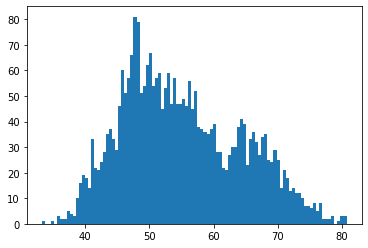

In [10]:
plt.hist(DA_pca1_explained_variance.values.flatten(), bins=100);

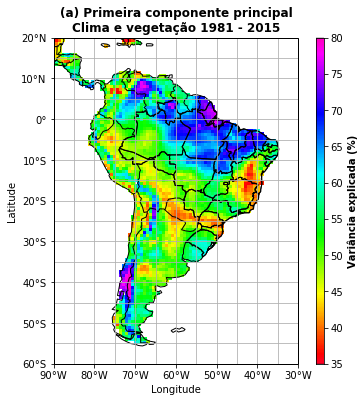

In [11]:
# Plot explained variance for the first component.
plotmap, axgr = cdlearn.maps.scalar_single_plot(
    data_array=DA_pca1_explained_variance,
    vmin=35,
    vmax=80,
    cmap=plt.cm.gist_rainbow,
    title="(a) Primeira componente principal\n" + \
          "Clima e vegetação 1981 - 2015",
    clabel="Variância explicada (%)",
    cticks=np.arange(35, 85, 5),
    figsize=(6, 6)
)

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pca1_pt.jpg", dpi=200, bbox_inches="tight")

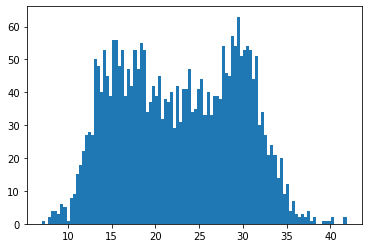

In [12]:
plt.hist(DA_pca2_explained_variance.values.flatten(), bins=100);

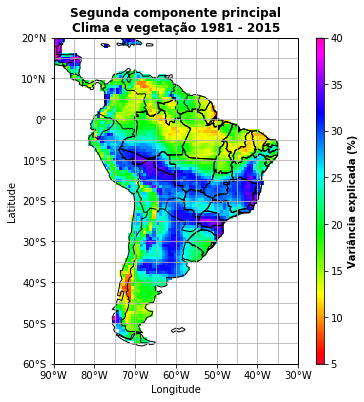

In [13]:
# Plot explained variance for the second component.
plotmap, axgr = cdlearn.maps.scalar_single_plot(
    data_array=DA_pca2_explained_variance,
    vmin=5,
    vmax=40,
    cmap=plt.cm.gist_rainbow,
    title="Segunda componente principal\n" + \
          "Clima e vegetação 1981 - 2015",
    clabel="Variância explicada (%)",
    cticks=np.arange(5, 45, 5),
    figsize=(6, 6)
)

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pca2_pt.jpg", dpi=200, bbox_inches="tight")

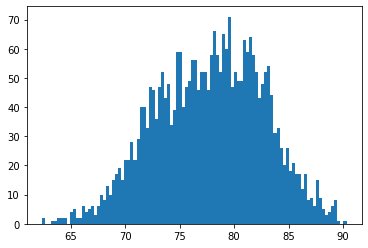

In [14]:
plt.hist(
    (DA_pca1_explained_variance + DA_pca2_explained_variance).values.flatten(), bins=100
);

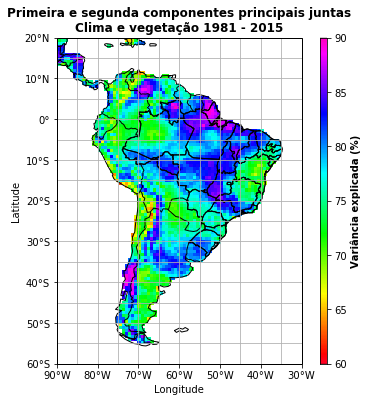

In [15]:
# Plot explained variance for the first and second components together.
plotmap, axgr = cdlearn.maps.scalar_single_plot(
    data_array=DA_pca1_explained_variance + 
               DA_pca2_explained_variance,
    vmin=60,
    vmax=90,
    cmap=plt.cm.gist_rainbow,
    title="Primeira e segunda componentes principais juntas\n" + \
          "Clima e vegetação 1981 - 2015",
    clabel="Variância explicada (%)",
    cticks=np.arange(60, 95, 5),
    figsize=(6, 6)
)

# Save figure.
plt.savefig(fig_path + "ndvi_climate_pca12_pt.jpg", dpi=200, bbox_inches="tight")

## 4 K-Means for the first principal component

In [16]:
# Hyper parameters.
hparams = {
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "tol": 0.0001,
    "precompute_distances": "auto",
    "verbose": 0,
    "random_state": None,
    "copy_x": True,
    "n_jobs": -1,
    "algorithm": "auto"
}

# Initialize my class.
clu = cdlearn.clustering.LandKmeansClustering(
    data_array=DA_pca1.fillna(value=-99), scaler=StandardScaler()
)

# List over which we search the best number of clusters.
ks = np.arange(3, 31, 1).tolist()
print(">>> ks size:", len(ks))

>>> ks size: 28


>>> Inertia:
* 3 clusters: 536369.4772193251; silhouette: 0.6947386572757587
* 4 clusters: 437516.0239782758; silhouette: 0.7291060193880124
* 5 clusters: 387844.4995567082; silhouette: 0.7460672841921072
* 6 clusters: 339961.19910802465; silhouette: 0.7545321076244318
* 7 clusters: 319848.1446526196; silhouette: 0.7578994296124911
* 8 clusters: 307315.515848735; silhouette: 0.7580510864142722
* 9 clusters: 297315.83196564845; silhouette: 0.7567728302410406
* 10 clusters: 285688.32587528514; silhouette: 0.7556323690472228
* 11 clusters: 279879.48307658697; silhouette: 0.7344015258035155
* 12 clusters: 268577.2276492688; silhouette: 0.7436106769112061
* 13 clusters: 259961.87664625226; silhouette: 0.7600672573781625
* 14 clusters: 252252.75387454132; silhouette: 0.7433770600497299
* 15 clusters: 245413.08108394497; silhouette: 0.7393717469558823
* 16 clusters: 239653.17020910504; silhouette: 0.7411956585066111
* 17 clusters: 233114.1246975385; silhouette: 0.741748798538851
* 18 clusters

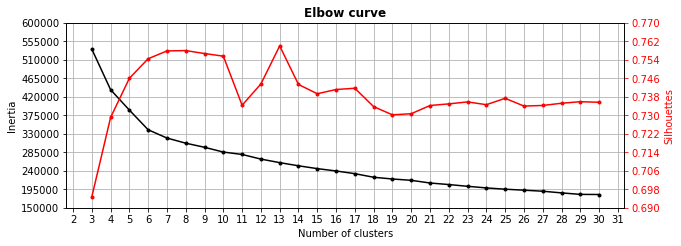

In [17]:
%%time

# Find the best number of clusters.
clu.elbow_curve_with_silhouette(
    hparameters=hparams, 
    ks=ks, 
    verbose=True
)

In [18]:
%%time

# Clustering using the best value for k.
best_k = 11 + 1 # Include spurious cluster from ocean.

hparams_best = {
    "n_clusters": best_k, 
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "tol": 0.0001,
    "precompute_distances": "auto",
    "verbose": 0,
    "random_state": None,
    "copy_x": True,
    "n_jobs": -1,
    "algorithm": "auto"
}

clu.run(hparameters=hparams_best)

CPU times: user 92.7 ms, sys: 79.4 ms, total: 172 ms
Wall time: 5.24 s


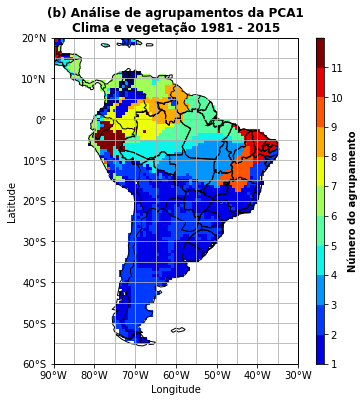

In [20]:
# Clusters on map.
plotmap, axgr = cdlearn.maps.scalar_single_plot(
    data_array=clu.clusters.where(clu.clusters.land_mask==True),
    vmin=1,
    vmax=best_k,
    levels=np.arange(1, best_k + 1, 1),
    cmap=plt.cm.jet,
    title="(b) Análise de agrupamentos da PCA1\n" + \
          "Clima e vegetação 1981 - 2015",
    clabel="Número do agrupamento",
    cticks=np.arange(1, best_k, 1),
    figsize=(6, 6)
)

# Save figure.
plt.savefig(fig_path + "ndvi_climate_kmeans_pt.jpg", dpi=200, bbox_inches="tight")